In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopandas import GeoDataFrame
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Point

sns.set_style('darkgrid')

In [38]:
sales_gdf = pd.read_csv('data/sales_gdf.csv')
census_gdf = gpd.read_file("https://data.cityofchicago.org/resource/bt9m-d2mf.geojson?$limit=9999999")
census_gdf["geo_12"] = census_gdf["geoid10"].map(lambda x: str(x)[:12])
neighborhood_gdf = gpd.read_file('../data/Boundaries - Neighborhoods.geojson')

In [39]:
final_df = pd.read_csv('data/Full_Data_long.csv')
final_df["geo_12"] = final_df["GEO_ID"].map(lambda x: str(x)[-12:])
final_df.info()
final_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218374 entries, 0 to 218373
Data columns (total 33 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   GEO_ID                    218353 non-null  object 
 1   Year                      218374 non-null  int64  
 2   pin                       218374 non-null  int64  
 3   sale_price                218374 non-null  float64
 4   age                       218374 non-null  int64  
 5   addr                      218371 non-null  object 
 6   hd_sf                     218374 non-null  float64
 7   n_units                   218374 non-null  float64
 8   bldg_sf                   132602 non-null  float64
 9   geometry                  218374 non-null  object 
 10  pri_neigh                 218374 non-null  object 
 11  sec_neigh                 218374 non-null  object 
 12  side                      218374 non-null  object 
 13  actual_sf                 218374 non-null  f

GEO_ID  Year             pin  sale_price  age  \
0  1500000US170318392002  2015  17273100931118     53000.0   44   
1  1500000US170313514001  2018  17343220150000    410000.0  130   
2  1500000US170318420001  2019  17341030641004    250000.0   11   

                  addr     hd_sf  n_units  bldg_sf  \
0  2921 S MICHIGAN AVE  365398.0    679.0      NaN   
1    3819 S WABASH AVE    3850.0      1.0   5050.0   
2        223 E 31ST ST    2738.0      3.0      NaN   

                                      geometry  ... Percent Black  \
0  POINT (-87.62257654590501 41.8402291575061)  ...      0.699771   
1  POINT (-87.62436774377279 41.8249549567756)  ...      0.917211   
2  POINT (-87.62080085952471 41.8381539098695)  ...           NaN   

  Percent HH with Children Percent Housing Vacant  Number of Public Schools  \
0                 0.265432               0.111835                       1.0   
1                 0.433090               0.062945                       1.0   
2                      NaN                    NaN                       NaN   

   crime_count  crimes_per_capita  station_id            station_name  \
0        209.0           0.159664     30382.0  Cermak-McCormick Place   
1        296.0           0.161220     30214.0    35th-Bronzeville-IIT   
2          NaN                NaN     30214.0    35th-Bronzeville-IIT   

   distance_miles        geo_12  
0        0.213983  170318392002  
1        0.183507  170313514001  
2        0.303191  170318420001  

[3 rows x 33 columns]

In [40]:
final_df[final_df['pri_neigh'] == 'Loop'][['pri_neigh', 'sale_price', 'addr', 'actual_sf']].sort_values(by='actual_sf')

pri_neigh  sale_price                 addr     actual_sf
178735      Loop     24000.0   235 W VAN BUREN ST     17.332037
180119      Loop     26000.0   235 W VAN BUREN ST     17.332037
180368      Loop    235000.0   235 W VAN BUREN ST     17.332037
179494      Loop    295000.0   235 W VAN BUREN ST     17.332037
180036      Loop    318500.0   235 W VAN BUREN ST     17.332037
...          ...         ...                  ...           ...
178855      Loop   1200000.0  1142 S MICHIGAN AVE   1068.750000
177823      Loop   1278500.0  1142 S MICHIGAN AVE   1068.750000
180439      Loop    215000.0    533 S PLYMOUTH CT   1921.000000
180830      Loop   1925000.0        192 N PARK DR  18187.222222
180611      Loop   1875000.0    225 N COLUMBUS DR  18187.222222

[3657 rows x 4 columns]

In [41]:
final_df['pricer_per_sqft'] = final_df['sale_price'] / final_df['actual_sf']
#final_df['pricer_per_unit'] = final_df['sale_price'] / final_df['n_units']
final_df_avgsale = pd.DataFrame(final_df.groupby('pri_neigh')['pricer_per_sqft'].mean().sort_values(ascending=False)).reset_index()
final_df_avgsale = final_df_avgsale.merge(sales_gdf[['pri_neigh', 'side']].drop_duplicates(), on='pri_neigh', how='left')
final_df_avgsale[final_df_avgsale['side'] == 'Central']

pri_neigh  pricer_per_sqft     side
0    Streeterville              inf  Central
1  Rush & Division      3952.285508  Central
2             Loop      3817.829633  Central
3      River North      3790.253389  Central
4       Gold Coast      2999.647596  Central
5     Printers Row      1788.759813  Central
8  Near South Side      1314.880008  Central

# Data Visualization

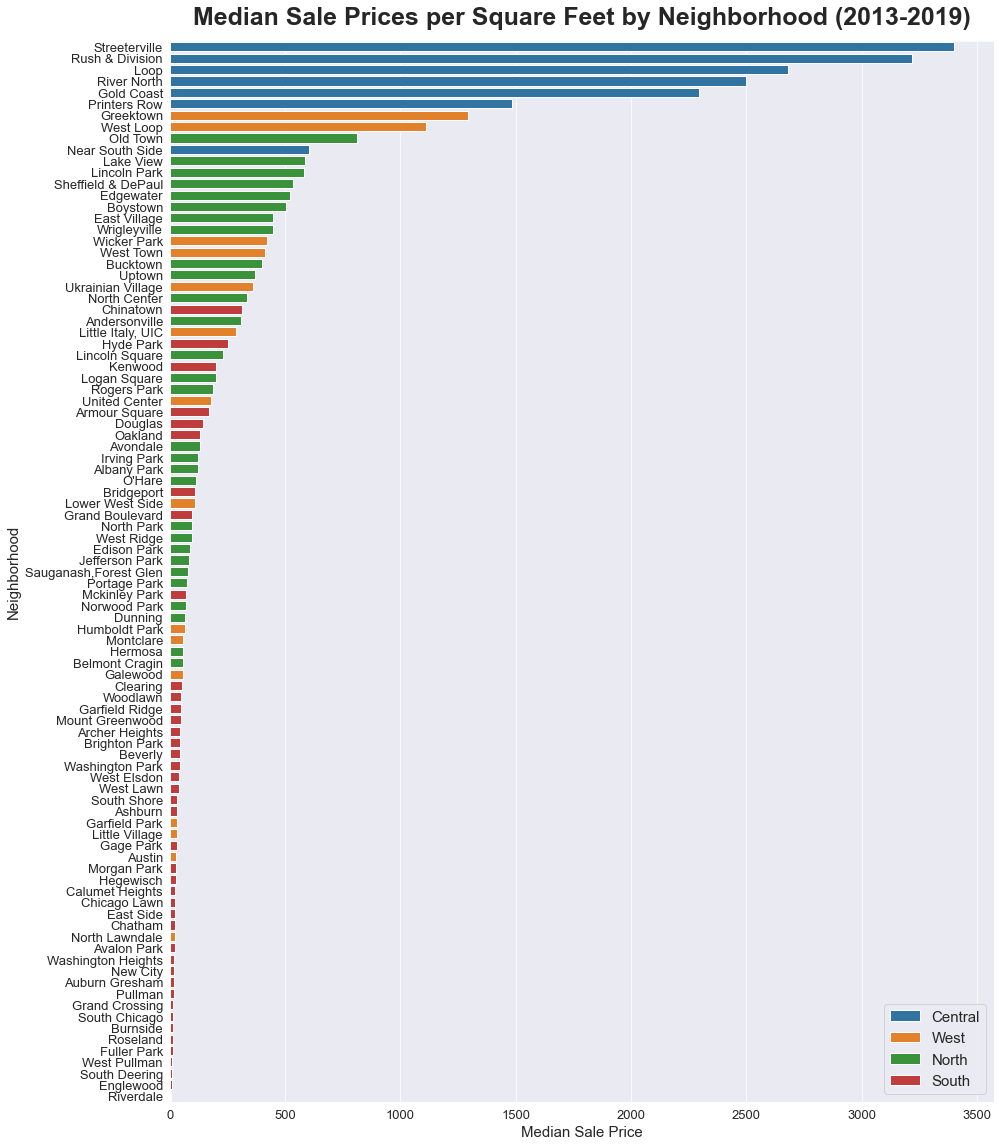

In [42]:
final_df['pricer_per_unit'] = final_df['sale_price'] / (final_df['hd_sf'] / final_df['n_units'])

final_df_avgsale = pd.DataFrame(final_df.groupby('pri_neigh')['pricer_per_unit'].median().sort_values(ascending=False)).reset_index()
final_df_avgsale = final_df_avgsale.merge(sales_gdf[['pri_neigh', 'side']].drop_duplicates(), on='pri_neigh', how='left')

fig, ax = plt.subplots(figsize=(14,16))

sns.barplot(final_df_avgsale.pricer_per_unit, final_df_avgsale.pri_neigh, hue=final_df_avgsale.side, dodge=False)
ax.set_title('Median Sale Prices per Square Feet by Neighborhood (2013-2019)', fontsize=25,
             fontweight="bold", loc='center', y=1.01)
ax.set_xlabel('Median Sale Price', fontsize=15)
ax.set_ylabel('Neighborhood', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='lower right', fontsize=15)

fig.tight_layout()
plt.savefig('figures/saleprice_per_sqft_by_nbh.png')
plt.show()

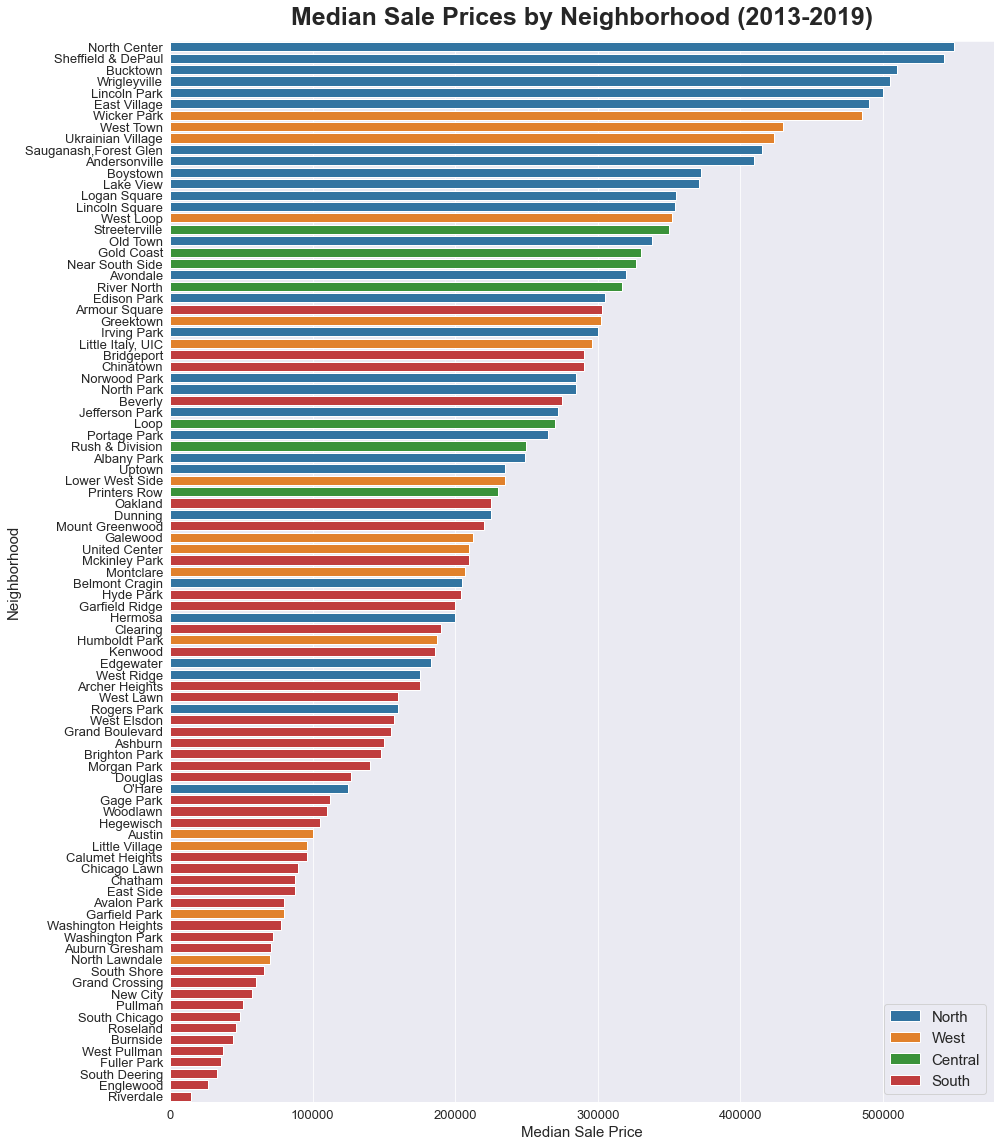

In [43]:
final_df_avgsale = pd.DataFrame(final_df.groupby('pri_neigh')['sale_price'].median().sort_values(ascending=False)).reset_index()
final_df_avgsale = final_df_avgsale.merge(sales_gdf[['pri_neigh', 'side']].drop_duplicates(), on='pri_neigh', how='left')

fig, ax = plt.subplots(figsize=(14,16))

sns.barplot(final_df_avgsale.sale_price, final_df_avgsale.pri_neigh, hue=final_df_avgsale.side, dodge=False)
ax.set_title('Median Sale Prices by Neighborhood (2013-2019)', fontsize=25,
             fontweight="bold", loc='center', y=1.01)
ax.set_xlabel('Median Sale Price', fontsize=15)
ax.set_ylabel('Neighborhood', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='lower right', fontsize=15)

fig.tight_layout()
plt.savefig('figures/median_saleprice_by_nbh.png')
plt.show()

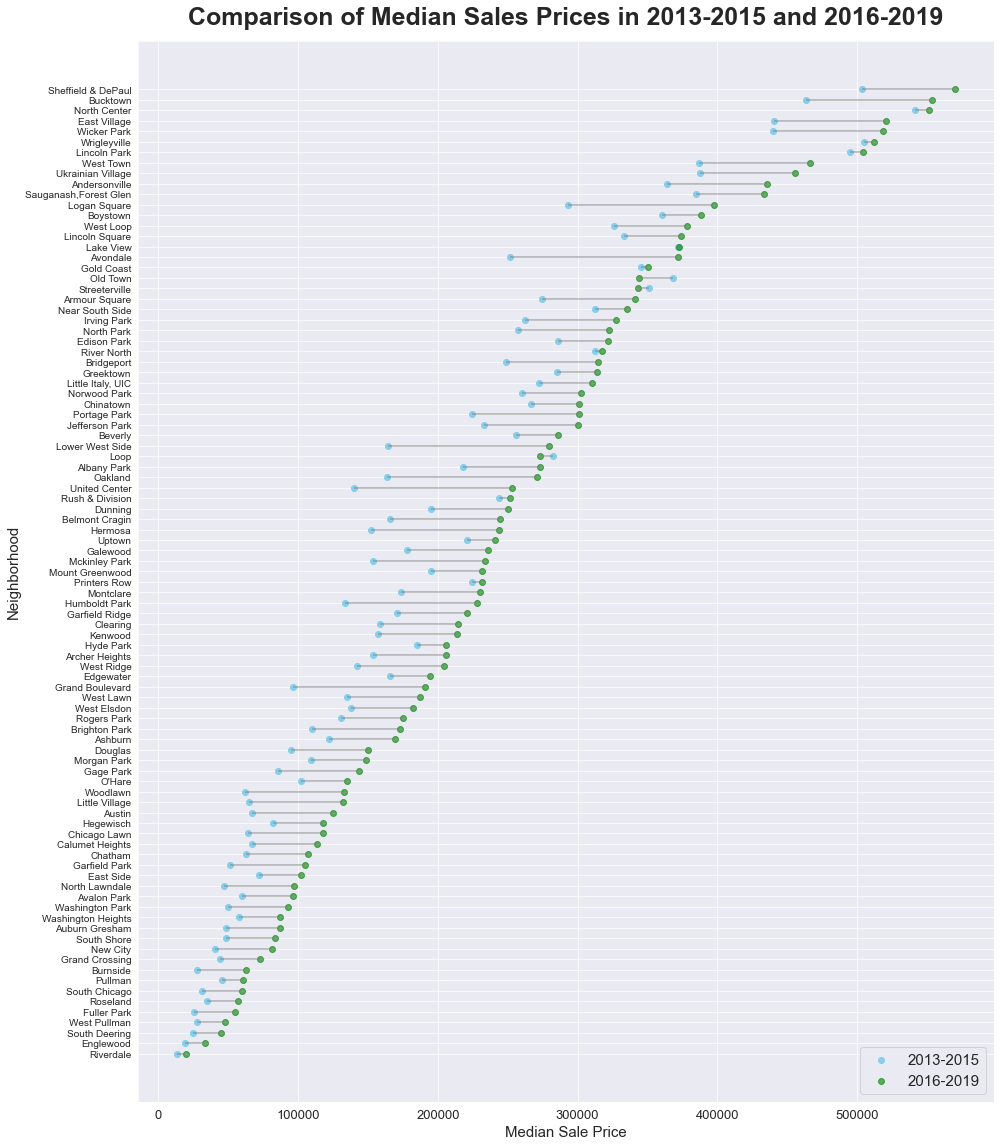

In [44]:
sales_compare = final_df.groupby(['pri_neigh', 'Year'])['sale_price'].median().unstack()
sales_compare['2013-2015'] = sales_compare[[2013, 2014, 2015]].mean(axis=1)
sales_compare['2016-2019'] = sales_compare[[2016, 2017, 2018, 2019]].mean(axis=1)
sales_compare = sales_compare[['2013-2015', '2016-2019']]
sales_compare = sales_compare.sort_values(by='2016-2019', ascending=True)


my_range=range(1,len(sales_compare.index)+1)
 
# The vertical plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
fig, ax = plt.subplots(figsize=(14,16))

plt.hlines(y=my_range, xmin=sales_compare['2013-2015'], xmax=sales_compare['2016-2019'], color='grey', alpha=0.6)
plt.scatter(sales_compare['2013-2015'], my_range, color='skyblue', alpha=1, label='2013-2015')
plt.scatter(sales_compare['2016-2019'], my_range, color='green', alpha=0.6 , label='2016-2019')
plt.legend()
 
# Add title and axis names
ax.set_title('Comparison of Median Sales Prices in 2013-2015 and 2016-2019', fontsize=25,
             fontweight="bold", loc='center', y=1.01)
ax.set_xlabel('Median Sale Price', fontsize=15)
ax.set_ylabel('Neighborhood', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(my_range, sales_compare.index)
plt.legend(loc='lower right', fontsize=15)

fig.tight_layout()
plt.savefig('figures/median_saleprice_avg.png')
plt.show()

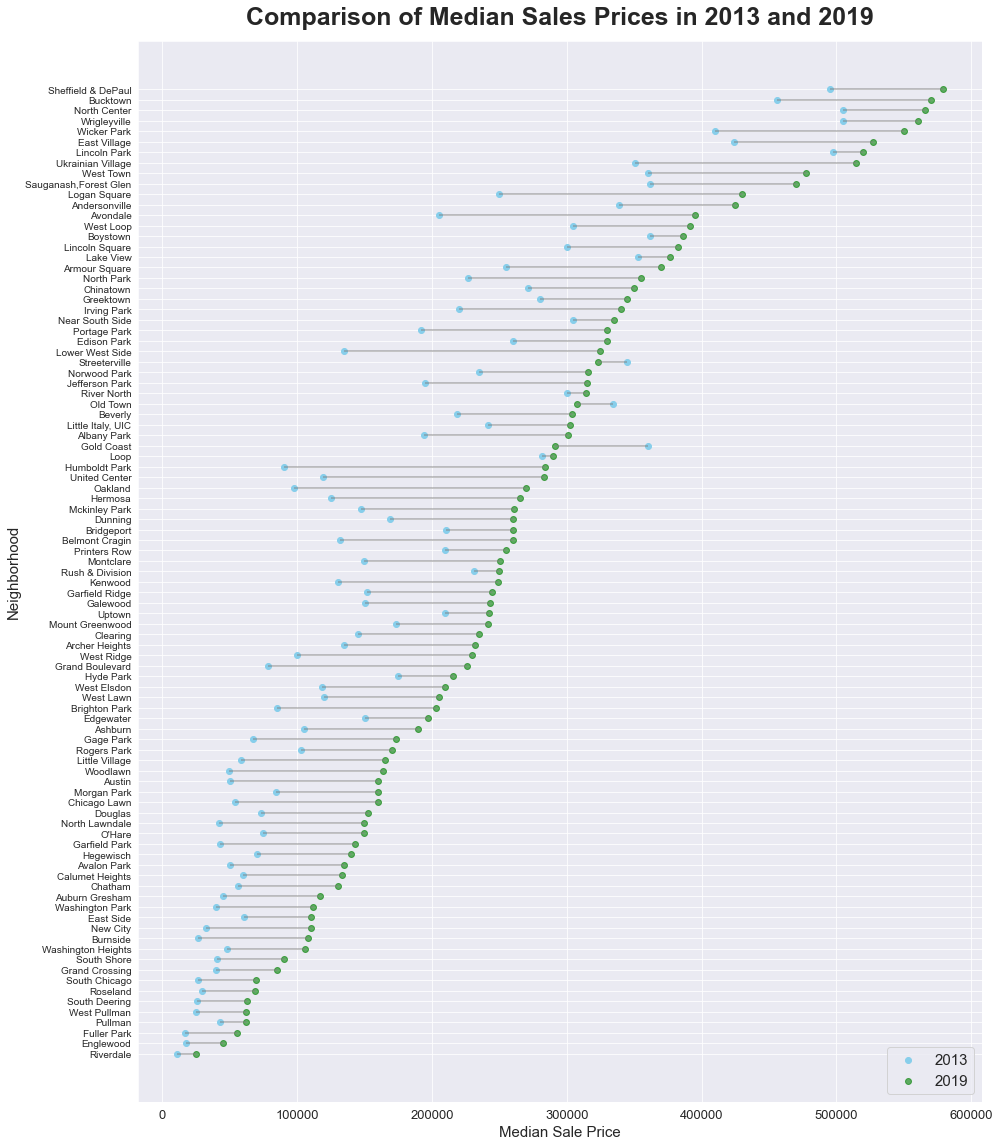

In [45]:
sales_compare_2 = final_df[(final_df['Year'] == 2013) | (final_df['Year'] == 2019)]
sales_compare_2 = sales_compare_2.groupby(['pri_neigh', 'Year'])['sale_price'].median().unstack()
sales_compare_2 = sales_compare_2.sort_values(by=2019, ascending=True)
sales_compare_2['diff'] = sales_compare_2[2019] - sales_compare_2[2013]


my_range=range(1,len(sales_compare_2.index)+1)
 
# The vertical plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
fig, ax = plt.subplots(figsize=(14,16))

plt.hlines(y=my_range, xmin=sales_compare_2[2013], xmax=sales_compare_2[2019], color='grey', alpha=0.6)
plt.scatter(sales_compare_2[2013], my_range, color='skyblue', alpha=1, label='2013')
plt.scatter(sales_compare_2[2019], my_range, color='green', alpha=0.6 , label='2019')
plt.legend()
 
# Add title and axis names
ax.set_title('Comparison of Median Sales Prices in 2013 and 2019', fontsize=25,
             fontweight="bold", loc='center', y=1.01)
ax.set_xlabel('Median Sale Price', fontsize=15)
ax.set_ylabel('Neighborhood', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(my_range, sales_compare_2.index)
plt.legend(loc='lower right', fontsize=15)

fig.tight_layout()
plt.savefig('figures/median_saleprice.png')
plt.show()

      side      2013      2014      2015      2016      2017      2018
0  Central  3.466284  3.434414  3.441419  3.319768  2.864886  2.858917
1    North  3.889184  4.290038  4.528302  4.528302  4.440913  4.227642
2    South  1.751501  2.087119  2.743069  2.777127  3.061474  3.190351
3     West  3.604115  4.224709  4.939682  4.823778  4.996813  4.964020


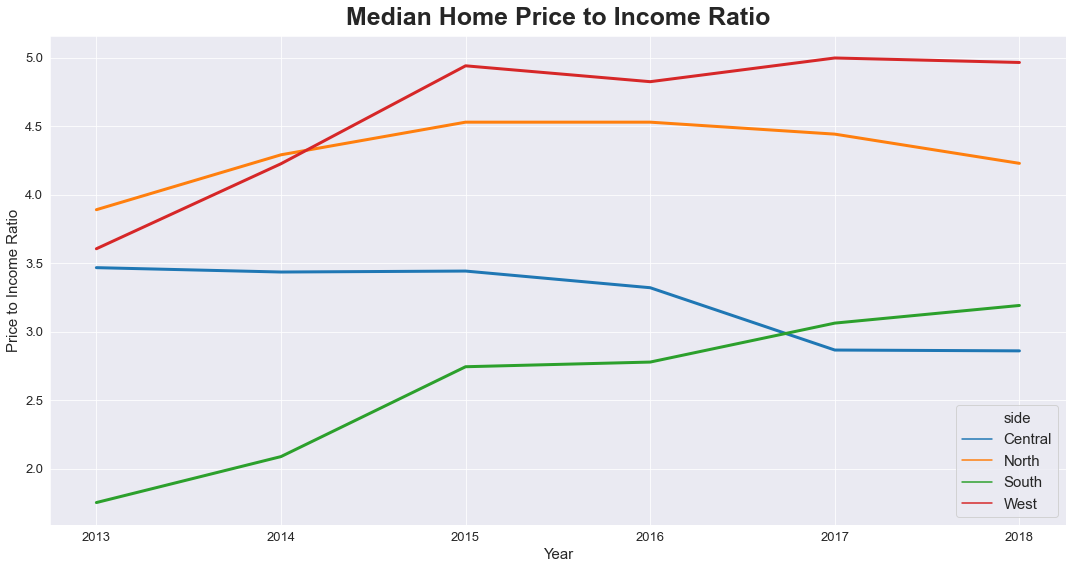

In [46]:
median_income_by_year = final_df.groupby(['side', 'Year'])['Median HH Income'].median().unstack()
median_price_by_year = final_df.groupby(['side', 'Year'])['sale_price'].median().unstack()
median_inc_to_price = pd.DataFrame()
for year in range(2013, 2019):
    median_inc_to_price[year] = median_price_by_year[year] / median_income_by_year[year]
median_inc_to_price = median_inc_to_price.reset_index()
print(median_inc_to_price.head())

median_inc_to_price = median_inc_to_price.melt(id_vars=["side"], var_name="year", value_name="price_to_income_ratio")

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(15,8))

sns.lineplot(x="year", y="price_to_income_ratio", hue='side', data=median_inc_to_price, lw=3)
ax.set_title('Median Home Price to Income Ratio', fontsize=25,
             fontweight="bold", loc='center', y=1.01)
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Price to Income Ratio', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='lower right', fontsize=15)

fig.tight_layout()
plt.savefig('figures/side_price_to_income_ratio.png')
plt.show()

        pri_neigh      2013      2014      2015      2016      2017      2018
63        Oakland  2.066203  2.300667  6.392447  4.417966  8.068127  9.681972
28    Fuller Park  0.834356  1.534884  1.017821  1.505665  1.614661  3.456749
21        Douglas  1.356222  2.812280  3.159225  3.600510  2.819977  4.189535
31  Garfield Park  1.484146  1.671034  2.579560  2.885574  3.448540  4.560394
57       New City  0.997755  1.347826  1.629265  2.002470  2.174163  2.903740


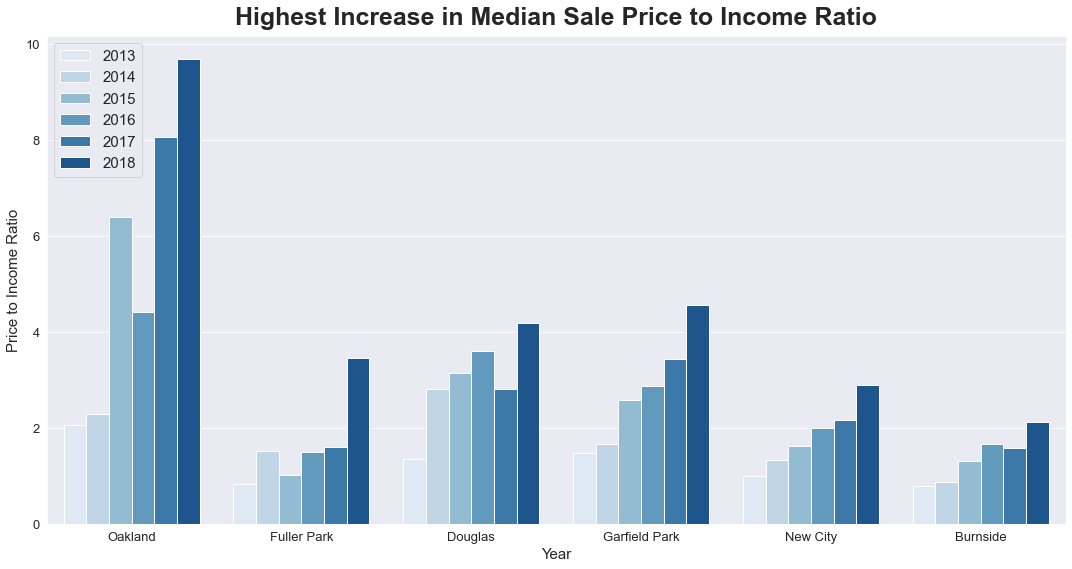

In [47]:
median_income_by_year = final_df.groupby(['pri_neigh', 'Year'])['Median HH Income'].median().unstack()
median_price_by_year = final_df.groupby(['pri_neigh', 'Year'])['sale_price'].median().unstack()
median_inc_to_price = pd.DataFrame()
for year in range(2013, 2019):
    median_inc_to_price[year] = median_price_by_year[year] / median_income_by_year[year]
median_inc_to_price = median_inc_to_price.reset_index()#.sort_values(by=2018, ascending=False)
median_inc_to_price['biggest_diff'] = (median_inc_to_price[2018] - median_inc_to_price[2013]) / median_inc_to_price[2013]
median_inc_to_price = median_inc_to_price.sort_values(by='biggest_diff', ascending=False)
median_inc_to_price = median_inc_to_price[['pri_neigh', 2013, 2014, 2015, 2016, 2017, 2018]]
print(median_inc_to_price.head())

median_inc_to_price = median_inc_to_price[:6].melt(id_vars=["pri_neigh"], var_name="year", value_name="price_to_income_ratio")

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(15,8))
#sns.palplot(sns.color_palette("Blues"))

sns.barplot(x="pri_neigh", y="price_to_income_ratio", hue="year", data=median_inc_to_price, palette="Blues")
#sns.barplot(x="year", y="price_to_income_ratio", hue="pri_neigh", data=median_inc_to_price)
#sns.lineplot(x="year", y="price_to_income_ratio", hue='pri_neigh', data=median_inc_to_price, lw=3)
ax.set_title('Highest Increase in Median Sale Price to Income Ratio', fontsize=25,
             fontweight="bold", loc='center', y=1.01)
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Price to Income Ratio', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left', fontsize=15)

fig.tight_layout()
plt.savefig('figures/neighborhood_price_to_income_ratio.png')
plt.show()

       pri_neigh   side  sale_price  Percent White  count
44     Lake View  North    371000.0       0.877754  12894
45  Lincoln Park  North    500000.0       0.879563   6530
81        Uptown  North    235000.0       0.713781   5340
65  Portage Park  North    265255.5       0.700915   5146
25     Edgewater  North    183000.0       0.708833   5025


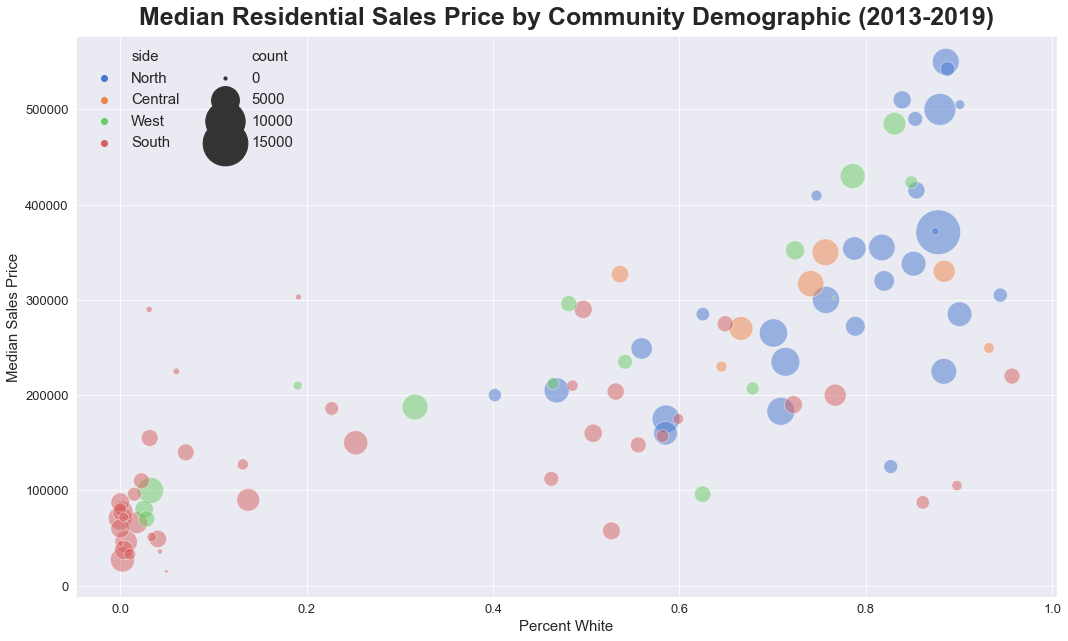

In [48]:
sale_pop = final_df.groupby(['pri_neigh', 'side']).agg({'sale_price':'median', 'Percent White':'median', 'pin':'count'})
sale_pop = sale_pop.reset_index().rename(columns={"pin": "count"})
sale_pop = sale_pop.sort_values(by='count', ascending=False)
print(sale_pop.head())

#sns.set(style="white")
fig, ax = plt.subplots(figsize=(15,9))

sns.scatterplot(x="Percent White", y="sale_price", hue="side", size="count",
                sizes=(10, 2000), alpha=.5, palette="muted", data=sale_pop)
ax.set_title('Median Residential Sales Price by Community Demographic (2013-2019)', fontsize=25,
             fontweight="bold", loc='center', y=1.01)
ax.set_xlabel('Percent White', fontsize=15)
ax.set_ylabel('Median Sales Price', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left', fontsize=15, ncol=2, frameon=False)

fig.tight_layout()
plt.savefig('figures/demographic_scatter.png')
plt.show()

In [49]:
# sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# # Initialize the FacetGrid object
# pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
# g = sns.FacetGrid(df, row="Year", hue="Year", aspect=5.5, height=2.2, palette=pal)

# # Draw the densities in a few steps
# g.map(sns.kdeplot, "sale_price", clip_on=False, shade=True, alpha=1, lw=10.5, bw=2)
# g.map(sns.kdeplot, "sale_price", clip_on=False, color="w", lw=2, bw=.2)
# g.map(plt.axhline, y=0, lw=2, clip_on=False)


# # Define and use a simple function to label the plot in axes coordinates
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(0.9, .1, label, fontweight="bold", color=color, fontsize=30,
#             ha="left", va="center", transform=ax.transAxes)


# g.map(label, "sale_price")

# # Set the subplots to overlap
# g.fig.subplots_adjust(hspace=-.8)

# # Remove axes details that don't play well with overlap
# g.set_titles("")
# g.set(yticks=[])
# g.despine(bottom=True, left=True)

# plt.savefig('figures/overlap_density.png')
# plt.show()

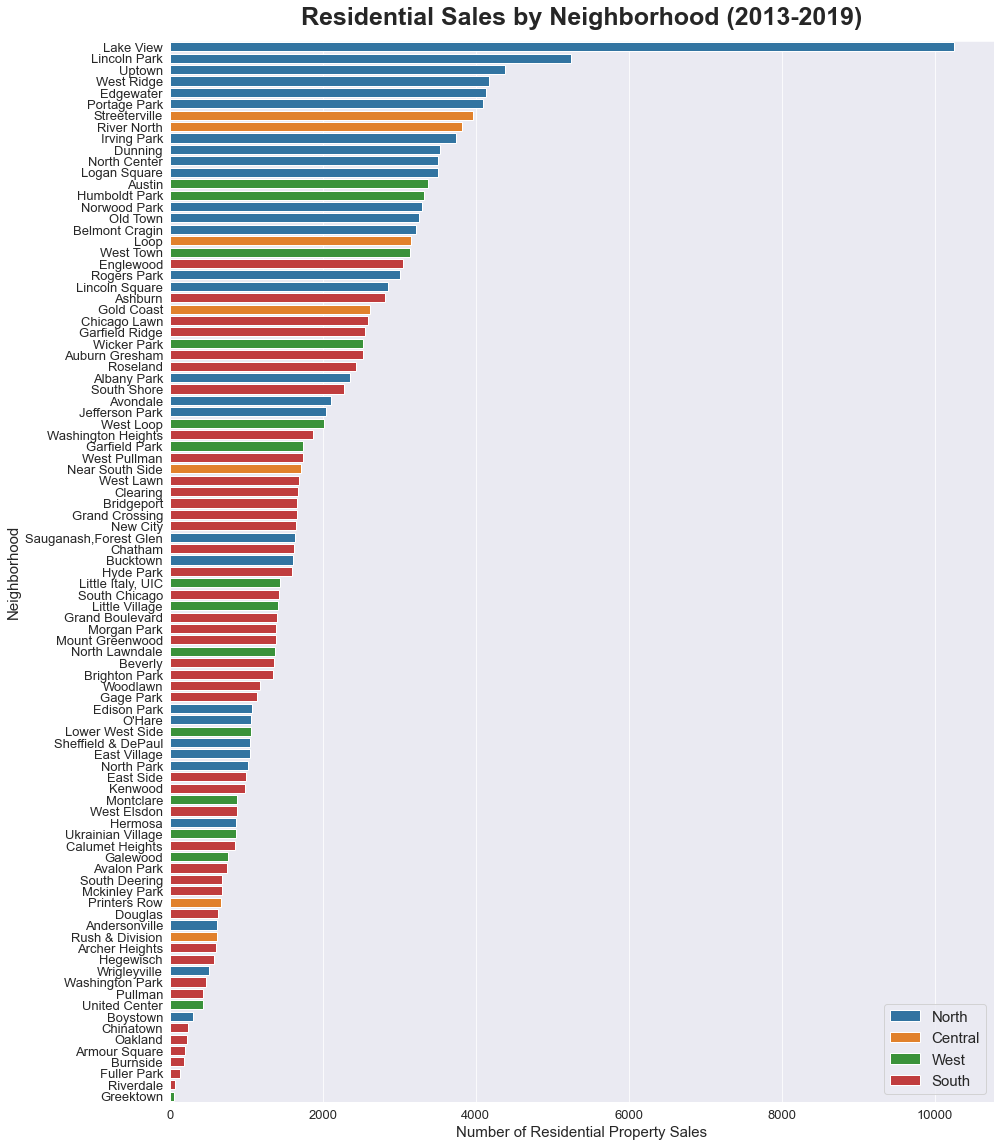

In [50]:
sales_gdf_count = pd.DataFrame(sales_gdf.groupby('pri_neigh')['pin'].nunique().sort_values(ascending=False)).reset_index()
sales_gdf_count = sales_gdf_count.merge(sales_gdf[['pri_neigh', 'side']].drop_duplicates(), on='pri_neigh', how='left')

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(14,16))

sns.barplot(sales_gdf_count.pin, sales_gdf_count.pri_neigh, hue=sales_gdf_count.side, dodge=False)
ax.set_title('Residential Sales by Neighborhood (2013-2019)', fontsize=25,
             fontweight="bold", loc='center', y=1.01)
ax.set_xlabel('Number of Residential Property Sales', fontsize=15)
ax.set_ylabel('Neighborhood', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='lower right', fontsize=15)

fig.tight_layout()
plt.savefig('figures/num_sales.png')
plt.show()

In [51]:
# income_compare = sales_gdf[['pri_neigh', '2013 Median Income', '2018 Median Income']]
# income_compare = income_compare.groupby('pri_neigh')[['2013 Median Income', '2018 Median Income']].mean()
# income_compare = income_compare.sort_values(by='2018 Median Income', ascending=True)

# my_range=range(1,len(income_compare.index)+1)
 
# # The vertical plot is made using the hline function
# fig, ax = plt.subplots(figsize=(13,20))

# plt.hlines(y=my_range, xmin=income_compare['2013 Median Income'], xmax=income_compare['2018 Median Income'], color='grey', alpha=0.6)
# plt.scatter(income_compare['2013 Median Income'], my_range, color='skyblue', alpha=1, label='2013')
# plt.scatter(income_compare['2018 Median Income'], my_range, color='green', alpha=0.6 , label='2019')
# plt.legend()
 
# # Add title and axis names
# ax.set_title('Comparison of Median Income in 2013 and 2018', fontsize=25,
#              fontweight="bold", loc='center', y=1.01)
# ax.set_xlabel('Median Income', fontsize=15)
# ax.set_ylabel('Neighborhood', fontsize=15)
# plt.xticks(fontsize=13)
# plt.yticks(my_range, income_compare.index)
# plt.legend(loc='lower right', fontsize=15)

# plt.show()

In [52]:
sales_compare = final_df.groupby(['geo_12', 'Year'])['sale_price'].median().unstack()
sales_compare['2013-2015'] = sales_compare[[2013, 2014, 2015]].mean(axis=1)
sales_compare['2016-2019'] = sales_compare[[2016, 2017, 2018, 2019]].mean(axis=1)
sales_compare['sales_price_diff'] = (sales_compare['2016-2019'] - sales_compare['2013-2015'])  / sales_compare['2013-2015']
sales_compare = sales_compare.reset_index()
sales_compare = sales_compare.sort_values(by='sales_price_diff')[:-6]
sales_compare

Year        geo_12      2013          2014       2015      2016          2017  \
359   170310810005       NaN  6.586000e+06        NaN  645000.0           NaN   
353   170310804002       NaN           NaN  1150000.0       NaN  565000.00000   
1080  170313510003  442000.0           NaN   465000.0  115000.0   85000.00000   
1626  170316708002   87500.0  9.200000e+04   115000.0   19000.0   30100.00000   
292   170310701021  188000.0  1.000500e+06    50000.0  137194.0  175000.00000   
...            ...       ...           ...        ...       ...           ...   
968   170312606001   16000.0  2.055000e+04    33000.0  135000.0   54900.00000   
1185  170314313011   24250.0  2.000000e+04    23300.0   45400.0  113500.00000   
1239  170314603023   34121.5  2.650000e+04    20450.0  133000.0  135000.00000   
1003  170312912001   36750.0  3.200000e+04    21000.0   87500.0  160500.00000   
1030  170313012002       NaN  2.652124e+04        NaN  112000.0   83360.24735   

Year           2018      2019     2013-2015      2016-2019  sales_price_diff  
359   545000.000000       NaN  6.586000e+06  595000.000000         -0.909657  
353    25000.000000   25000.0  1.150000e+06  205000.000000         -0.821739  
1080  128900.000000  145000.0  4.535000e+05  118475.000000         -0.738754  
1626   45000.000000   37500.0  9.816667e+04   32900.000000         -0.664856  
292   192000.000000  181700.0  4.128333e+05  171473.500000         -0.584642  
...             ...       ...           ...            ...               ...  
968    88000.000000  105500.0  2.318333e+04   95850.000000          3.134436  
1185   65700.000000  152900.0  2.251667e+04   94375.000000          3.191340  
1239  147314.850717   42500.0  2.702383e+04  114453.712679          3.235288  
1003  101750.000000  220000.0  2.991667e+04  142437.500000          3.761142  
1030  159000.000000  155000.0  2.652124e+04  127340.061837          3.801436  

[2144 rows x 11 columns]

In [53]:
# import censusdata
# import geopandas as gpd

# acs_example = censusdata.download("acs5", 2015, censusdata.censusgeo(
#     [("state", "17"), ("county", "031"), ("block group", "*")]), ["B02001_001E", "GEO_ID"])

# # Download Census block boundaries for Chicago 
# #census_gdf = gpd.read_file("https://data.cityofchicago.org/resource/bt9m-d2mf.geojson?$limit=9999999")

# # Extract 12-digit FIPS code from both datasets 
# census_gdf["geo_12"] = census_gdf["geoid10"].map(lambda x: str(x)[:12])
# acs_example["geo_12"] = acs_example["GEO_ID"].map(lambda x: str(x)[-12:])

# # Merge ACS data with Census block boundaries 
# # Assumes the crime df was converted to a geopandas df (crime_gdf)  
# merged_gdf = (gpd.GeoDataFrame(acs_example.merge(census_gdf, on="geo_12", how="inner"), 
#                                crs=crime_gdf.crs))

# # Limit columns 
# limited_gdf = merged_gdf[["B02001_001E", "GEO_ID", "geometry"]].drop_duplicates()

# # Plot geopandas dataframe with total population by Census block
# limited_gdf.plot()

# # Print a sample of rows 
# limited_gdf.sample(3)

         geo_12  sales_price_diff  \
0  170310810005         -0.909657   
1  170310810005         -0.909657   
2  170310810005         -0.909657   
3  170310810005         -0.909657   
4  170310810005         -0.909657   

                                            geometry  
0  MULTIPOLYGON (((-87.63363 41.89660, -87.63392 ...  
1  MULTIPOLYGON (((-87.63388 41.90221, -87.63387 ...  
2  MULTIPOLYGON (((-87.63265 41.89661, -87.63279 ...  
3  MULTIPOLYGON (((-87.63290 41.90054, -87.63306 ...  
4  MULTIPOLYGON (((-87.63125 41.89664, -87.63155 ...  


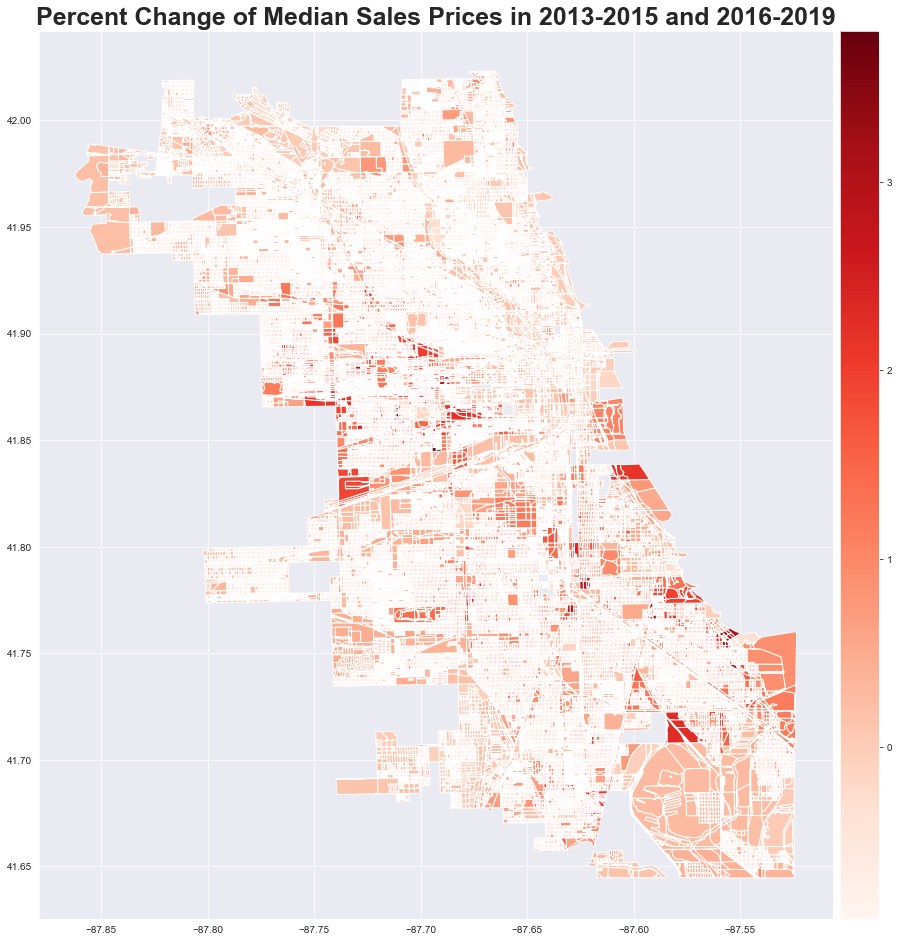

In [54]:
merged_gdf = sales_compare[['geo_12', 'sales_price_diff']]\
    .merge(census_gdf[['geo_12', 'geometry']], on='geo_12', how="left")
merged_gdf = gpd.GeoDataFrame(merged_gdf.drop_duplicates()).sort_values(by='sales_price_diff')
print(merged_gdf.head())

fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax = merged_gdf.plot(column='sales_price_diff', legend=True, cmap='Reds', ax=ax, cax=cax)
ax.set_title('Percent Change of Median Sales Prices in 2013-2015 and 2016-2019', fontsize=25,
             fontweight="bold", loc='center', y=2.12)

fig.tight_layout()
plt.savefig('figures/censusblock_saleprice_change_heatmap.png')
plt.show()

        pri_neigh  sales_price_diff  \
64       Old Town         -0.066361   
50           Loop         -0.033756   
78  Streeterville         -0.022544   
44      Lake View          0.001512   
33     Gold Coast          0.014450   

                                             geometry  
64  MULTIPOLYGON (((-87.63612 41.91847, -87.63569 ...  
50  MULTIPOLYGON (((-87.61397 41.88841, -87.61325 ...  
78  MULTIPOLYGON (((-87.61369 41.89313, -87.61369 ...  
44  MULTIPOLYGON (((-87.66402 41.94728, -87.66402 ...  
33  MULTIPOLYGON (((-87.62646 41.91147, -87.62640 ...  


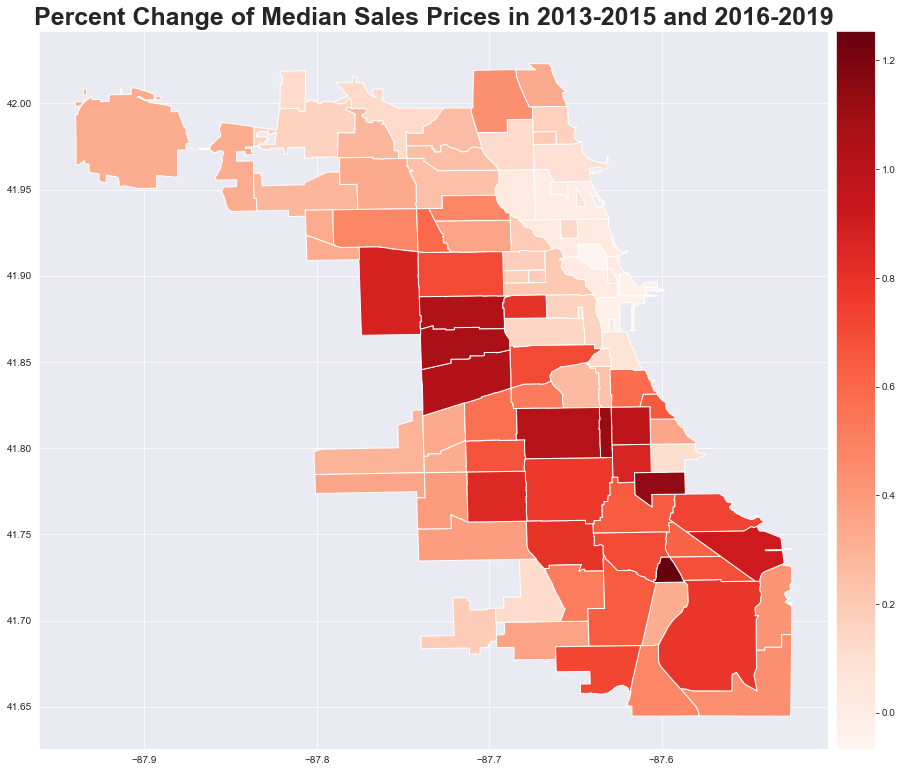

In [55]:
sales_compare = final_df.groupby(['pri_neigh', 'Year'])['sale_price'].median().unstack()
sales_compare['2013-2015'] = sales_compare[[2013, 2014, 2015]].mean(axis=1)
sales_compare['2016-2019'] = sales_compare[[2016, 2017, 2018, 2019]].mean(axis=1)
sales_compare['sales_price_diff'] = (sales_compare['2016-2019'] - sales_compare['2013-2015'])  / sales_compare['2013-2015']
#sales_compare['sales_price_diff'] = sales_compare['2016-2019'] - sales_compare['2013-2015']

sales_compare = sales_compare.reset_index()
sales_compare = sales_compare[['pri_neigh', 'sales_price_diff']]\
    .merge(neighborhood_gdf[['pri_neigh', 'geometry']], on='pri_neigh', how="left")
sales_compare = gpd.GeoDataFrame(sales_compare.drop_duplicates()).sort_values(by='sales_price_diff')
print(sales_compare.head())

fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax = sales_compare.plot(column='sales_price_diff', legend=True, cmap='Reds', ax=ax, cax=cax)
ax.set_title('Percent Change of Median Sales Prices in 2013-2015 and 2016-2019', fontsize=25,
             fontweight="bold", loc='center', y=2.12)

fig.tight_layout()
plt.savefig('figures/saleprice_change_heatmap.png')
plt.show()


          pri_neigh  price_income_diff  \
92     Printers Row          -0.300500   
90  Near South Side          -0.181503   
82     North Center          -0.164953   
83      River North          -0.148524   
84        Greektown          -0.142458   

                                             geometry  
92  MULTIPOLYGON (((-87.62761 41.87437, -87.62760 ...  
90  MULTIPOLYGON (((-87.61666 41.85779, -87.61657 ...  
82  MULTIPOLYGON (((-87.67336 41.93234, -87.67342 ...  
83  MULTIPOLYGON (((-87.63145 41.90390, -87.63144 ...  
84  MULTIPOLYGON (((-87.64581 41.87541, -87.64589 ...  


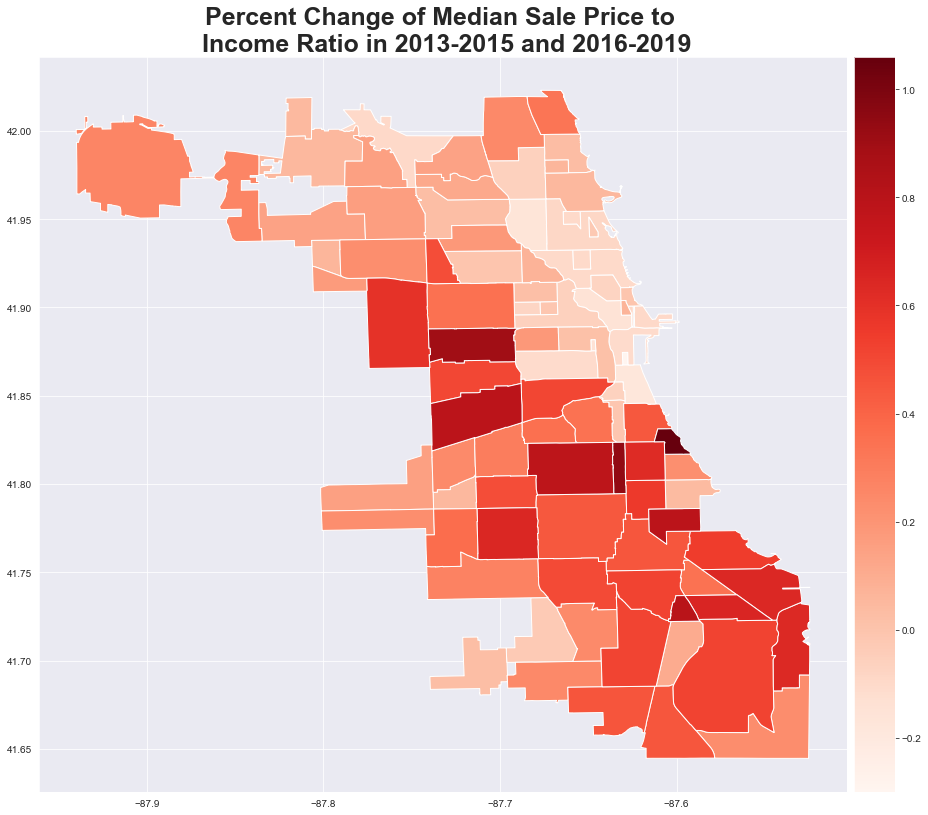

In [56]:
median_income_by_year = final_df.groupby(['pri_neigh', 'Year'])['Median HH Income'].median().unstack()
median_price_by_year = final_df.groupby(['pri_neigh', 'Year'])['sale_price'].median().unstack()
median_inc_to_price = pd.DataFrame()
for year in range(2013, 2019):
    median_inc_to_price[year] = median_price_by_year[year] / median_income_by_year[year]
median_inc_to_price = median_inc_to_price.reset_index()#.sort_values(by=2018, ascending=False)
median_inc_to_price['biggest_diff'] = (median_inc_to_price[2018] - median_inc_to_price[2013]) / median_inc_to_price[2013]
median_inc_to_price = median_inc_to_price.sort_values(by='biggest_diff', ascending=False)
median_inc_to_price = median_inc_to_price[['pri_neigh', 2013, 2014, 2015, 2016, 2017, 2018]]

median_inc_to_price['2013-2015'] = median_inc_to_price[[2013, 2014, 2015]].mean(axis=1)
median_inc_to_price['2016-2018'] = median_inc_to_price[[2016, 2017, 2018]].mean(axis=1)
median_inc_to_price['price_income_diff'] = (median_inc_to_price['2016-2018'] - median_inc_to_price['2013-2015'])\
    / median_inc_to_price['2013-2015']
median_inc_to_price = median_inc_to_price[['pri_neigh', 'price_income_diff']]\
    .merge(neighborhood_gdf[['pri_neigh', 'geometry']], on='pri_neigh', how="left")
median_inc_to_price = gpd.GeoDataFrame(median_inc_to_price.drop_duplicates()).sort_values(by='price_income_diff')
print(median_inc_to_price.head())

fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax = median_inc_to_price.plot(column='price_income_diff', legend=True, cmap='Reds', ax=ax, cax=cax)
ax.set_title('Percent Change of Median Sale Price to \n Income Ratio in 2013-2015 and 2016-2019', fontsize=25,
             fontweight="bold", loc='center', y=2.12)

fig.tight_layout()
plt.savefig('figures/saleprice_income_ratio_change_heatmap.png')
plt.show()

## PREDICTIONS

In [87]:
pred_2020 = pd.read_csv('data/2020_predictions.csv')
pred_2020

Unnamed: 0                 GEO_ID  Year  predicted_price_p_house
0              0  1500000US170310101001  2020            253721.332087
1              1  1500000US170310101002  2020            220409.407815
2              2  1500000US170310101003  2020            269724.958887
3              3  1500000US170310102011  2020            292534.900604
4              4  1500000US170310102012  2020            208033.354156
...          ...                    ...   ...                      ...
2207        2207  1500000US170318439001  2020            219031.988242
2208        2208  1500000US170318439002  2020            278160.745248
2209        2209  1500000US170318439003  2020             94585.717911
2210        2210  1500000US170318439004  2020            123974.026543
2211        2211  1500000US170318439005  2020            111238.851315

[2212 rows x 4 columns]

In [86]:
pred_2019 = pd.read_csv('data/2019_predictions.csv')
pred_2019

Unnamed: 0                 GEO_ID  Year  actual_price_p_house  \
0              4  1500000US170310101001  2019         134078.592593   
1              9  1500000US170310101002  2019         234178.571429   
2             14  1500000US170310101003  2019         223906.250000   
3             19  1500000US170310102011  2019         309558.875000   
4             24  1500000US170310102012  2019         175094.416667   
...          ...                    ...   ...                   ...   
2198       11002  1500000US170318439001  2019         121775.000000   
2199       11007  1500000US170318439002  2019         310000.000000   
2200       11012  1500000US170318439003  2019          58555.555556   
2201       11017  1500000US170318439004  2019         136800.000000   
2202       11022  1500000US170318439005  2019          72525.000000   

      predicted_price_p_house  
0               238147.703759  
1               193705.993637  
2               278079.404739  
3               279062.472205  
4               189514.312716  
...                       ...  
2198            167423.432029  
2199            255548.745445  
2200            105833.073292  
2201            213132.045238  
2202            182200.173008  

[2203 rows x 5 columns]

In [129]:
df_2019 = pd.read_csv('data/2019_predictions.csv')
df_2019["geo_12"] = df_2019["GEO_ID"].map(lambda x: str(x)[-12:])
df_2019 = df_2019[['Year', 'actual_price_p_house', 'predicted_price_p_house', 'geo_12']]\
    .merge(census_gdf[['geo_12', 'geometry']], on='geo_12', how="left")
df_2019 = gpd.GeoDataFrame(df_2019.drop_duplicates())
df_2019_block = gpd.sjoin(df_2019, neighborhood_gdf, how='inner', op='intersects')
df_2019_neigh = gpd.sjoin(neighborhood_gdf, df_2019, how='inner', op='intersects')

df_2020 = pd.read_csv('data/2020_predictions.csv')
df_2020["geo_12"] = df_2020["GEO_ID"].map(lambda x: str(x)[-12:])
df_2020 = df_2020[['Year', 'predicted_price_p_house', 'geo_12']]\
    .merge(census_gdf[['geo_12', 'geometry']], on='geo_12', how="left")
df_2020 = gpd.GeoDataFrame(df_2020.drop_duplicates())
df_2020_block = gpd.sjoin(df_2020, neighborhood_gdf, how='inner', op='intersects')
df_2020_neigh = gpd.sjoin(neighborhood_gdf, df_2020, how='inner', op='intersects')

C:\Users\ymeri\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\ymeri\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(epsg:4326 != None)
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\ymeri\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\ymeri\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(epsg:4326 != None)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [150]:
# df_dict = {df_2019_block: ['actual_price_p_house', 'predicted_price_p_house'],
#            df_2019_neigh: ['actual_price_p_house', 'predicted_price_p_house'],
#            df_2020_block: ['predicted_price_p_house'],
#            df_2020_neigh: ['predicted_price_p_house']}

# for df_year in [(df, col) for df, cols in df_dict.items() for col in cols]:
#     for col in ['actual_price_p_house', 'predicted_price_p_house']:
#         fig, ax = plt.subplots(1, 1, figsize=(13,20))
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes("right", size="5%", pad=0.1)

#         ax = df_year.plot(column=col, legend=True, cmap='Reds', ax=ax, cax=cax)
#         ax.set_title('{}, {}'.format(df.Year[0], col.split('_')[0]), fontsize=25,
#              fontweight="bold", loc='center', y=2.12)
        
#         fig.tight_layout()
#         plt.savefig('figures/{}_{}_census_block.png'.format(df.Year[0], col.split('_')[0]))
#         plt.show()

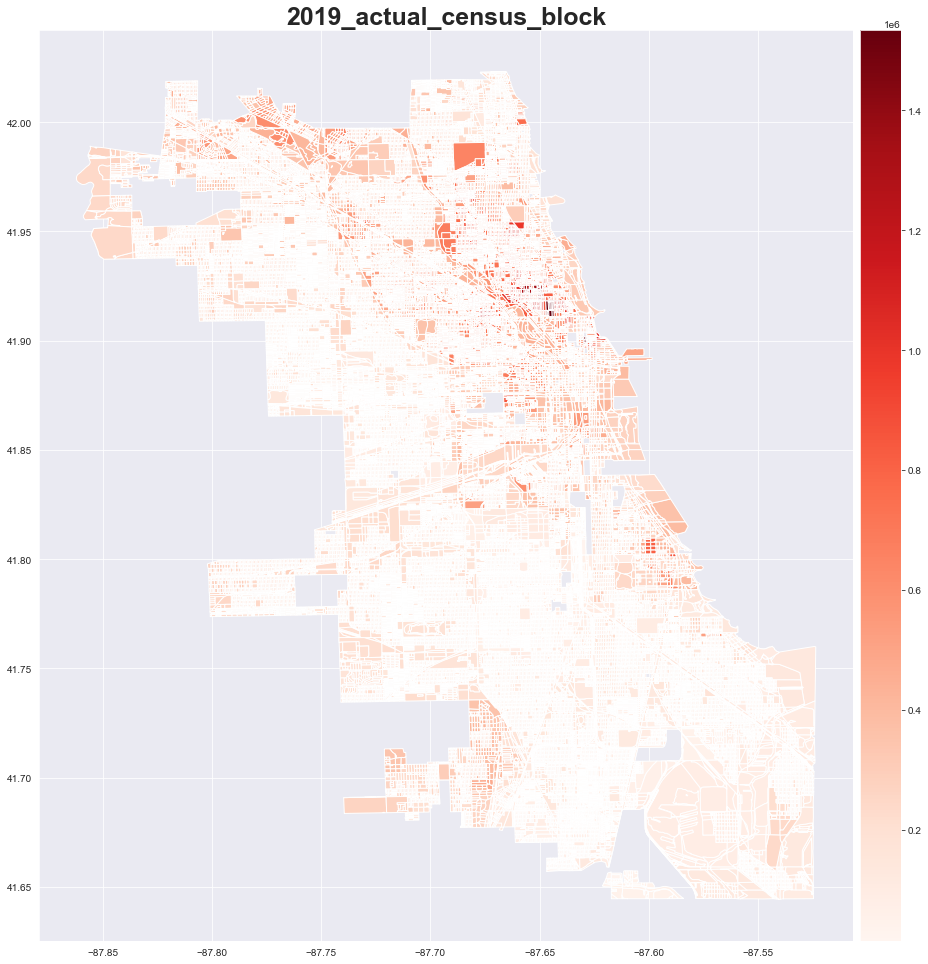

In [153]:
fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

table_name = '2019_actual_census_block'
ax = df_2019_block.plot(column='actual_price_p_house', legend=True, cmap='Reds', ax=ax, cax=cax)
ax.set_title(table_name, fontsize=25, fontweight="bold", loc='center', y=2.12)
fig.tight_layout()
plt.savefig('figures/{}.png'.format(table_name))
plt.show()

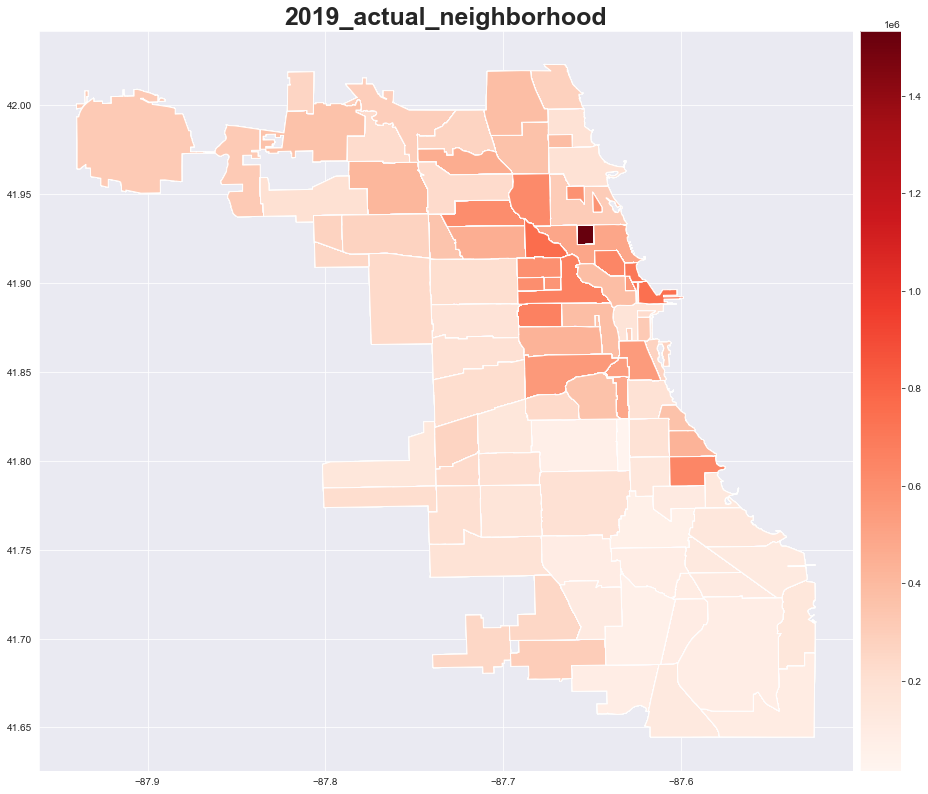

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

table_name = '2019_actual_neighborhood'
ax = df_2019_neigh.plot(column='actual_price_p_house', legend=True, cmap='Reds', ax=ax, cax=cax)
ax.set_title(table_name, fontsize=25, fontweight="bold", loc='center', y=2.12)
fig.tight_layout()
plt.savefig('figures/{}.png'.format(table_name))
plt.show()

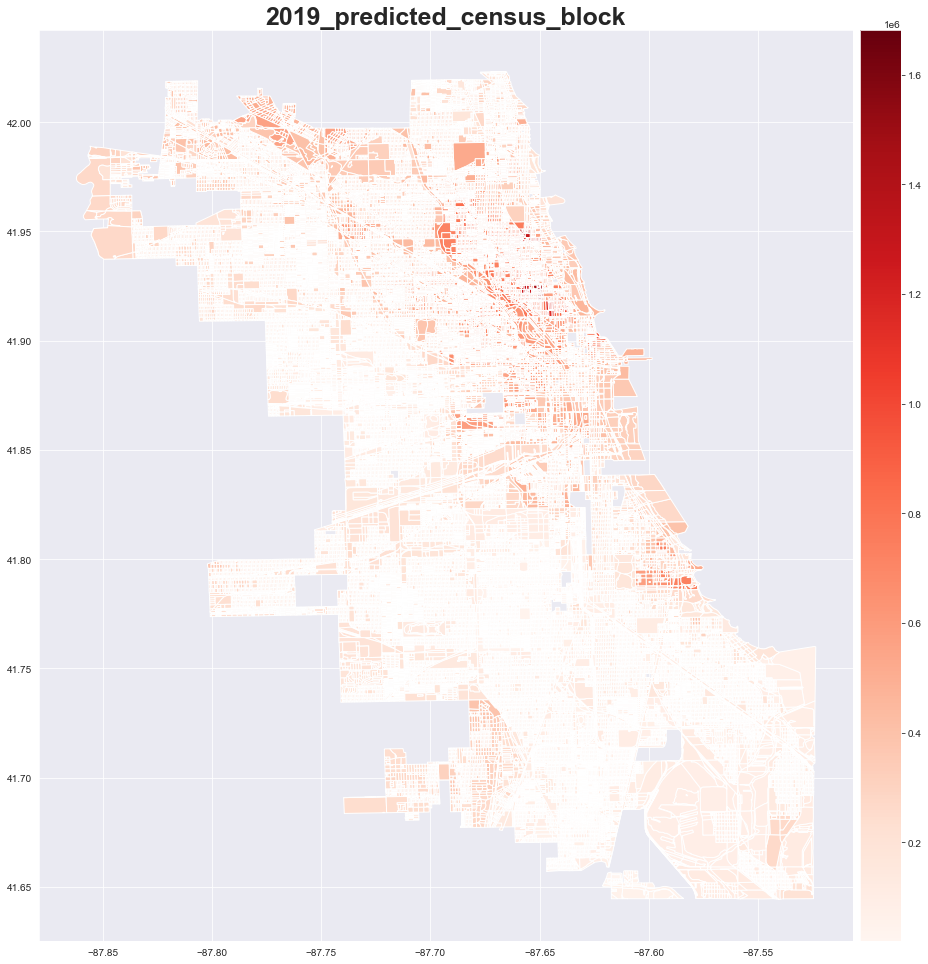

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

table_name = '2019_predicted_census_block'
ax = df_2019_block.plot(column='predicted_price_p_house', legend=True, cmap='Reds', ax=ax, cax=cax)
ax.set_title(table_name, fontsize=25, fontweight="bold", loc='center', y=2.12)
fig.tight_layout()
plt.savefig('figures/{}.png'.format(table_name))
plt.show()

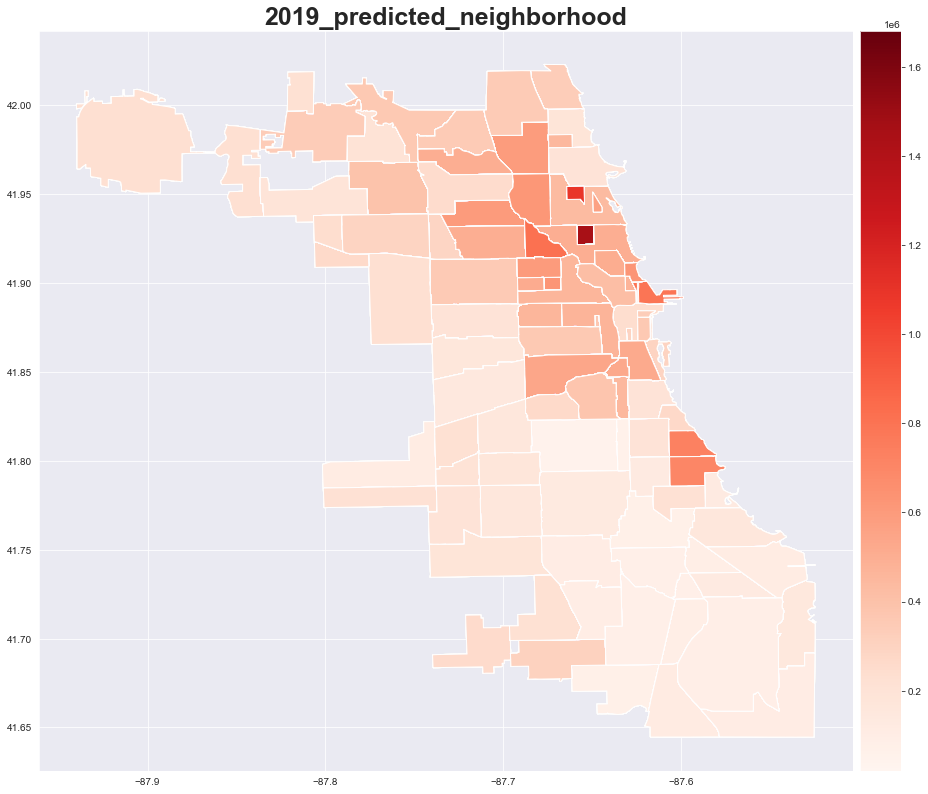

In [158]:
fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

table_name = '2019_predicted_neighborhood'
ax = df_2019_neigh.plot(column='predicted_price_p_house', legend=True, cmap='Reds', ax=ax, cax=cax)
ax.set_title(table_name, fontsize=25, fontweight="bold", loc='center', y=2.12)
fig.tight_layout()
plt.savefig('figures/{}.png'.format(table_name))
plt.show()

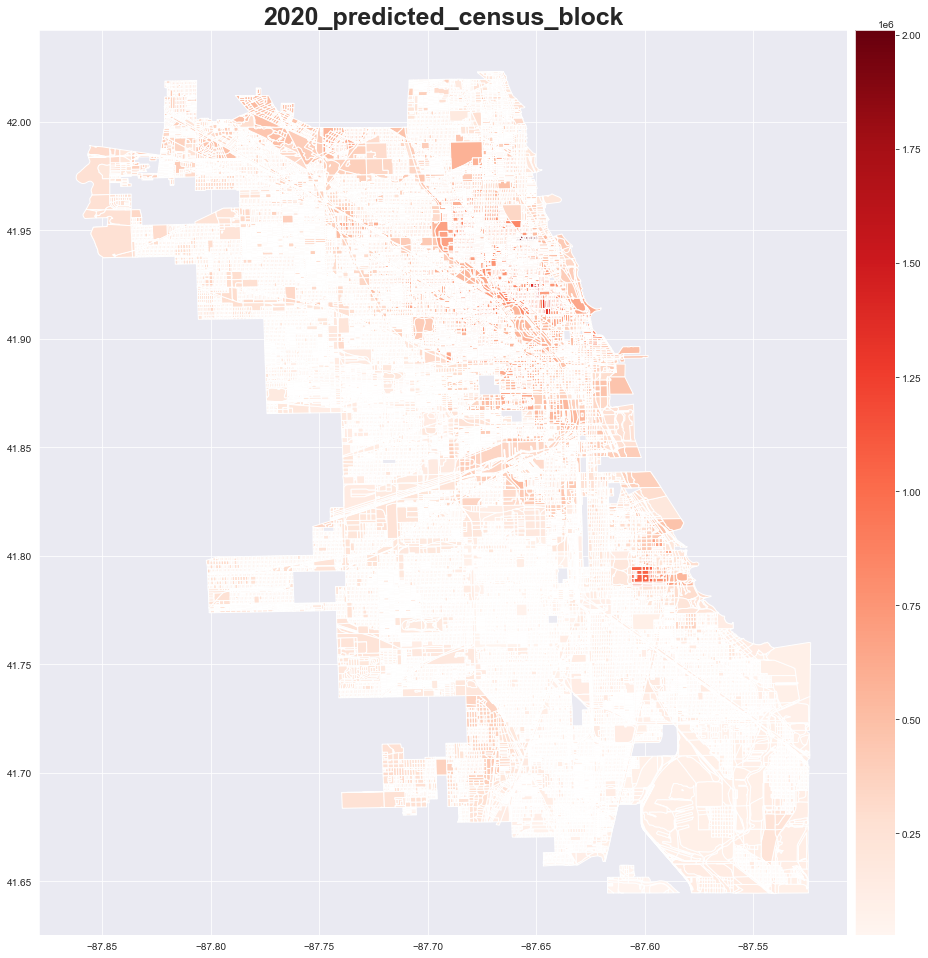

In [156]:
fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

table_name = '2020_predicted_census_block'
ax = df_2020_block.plot(column='predicted_price_p_house', legend=True, cmap='Reds', ax=ax, cax=cax)
ax.set_title(table_name, fontsize=25, fontweight="bold", loc='center', y=2.12)
fig.tight_layout()
plt.savefig('figures/{}.png'.format(table_name))
plt.show()

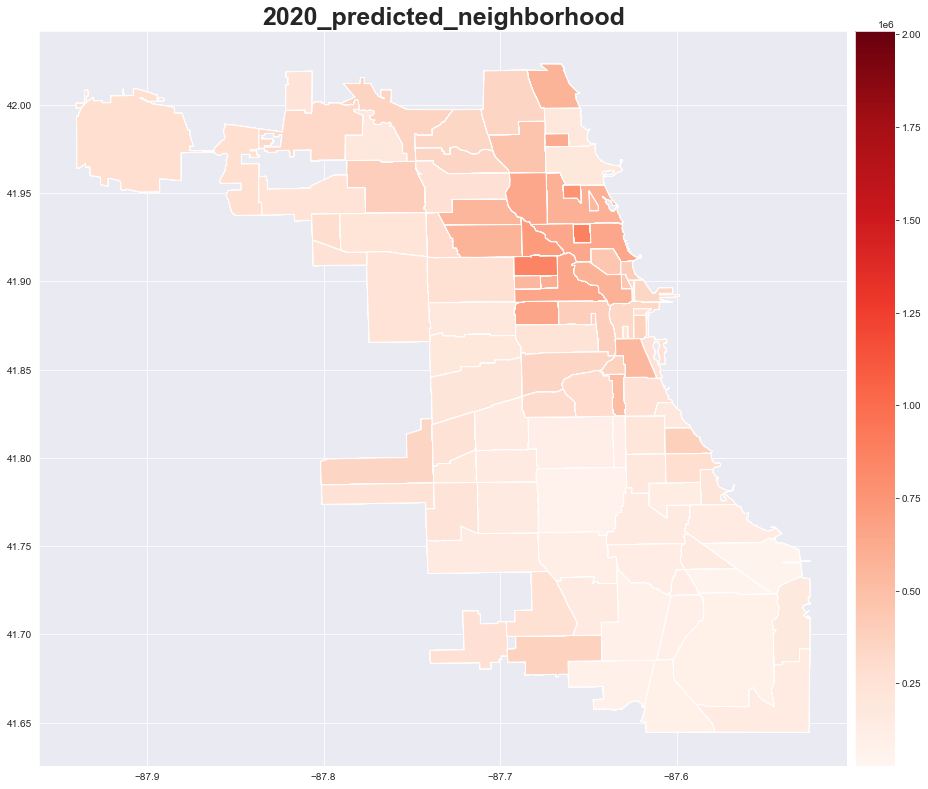

In [157]:
fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

table_name = '2020_predicted_neighborhood'
ax = df_2020_neigh.plot(column='predicted_price_p_house', legend=True, cmap='Reds', ax=ax, cax=cax)
ax.set_title(table_name, fontsize=25, fontweight="bold", loc='center', y=2.12)
fig.tight_layout()
plt.savefig('figures/{}.png'.format(table_name))
plt.show()

In [ ]:
sales_compare = final_df.groupby(['pri_neigh', 'Year'])['sale_price'].median().unstack()
sales_compare['2013-2015'] = sales_compare[[2013, 2014, 2015]].mean(axis=1)
sales_compare['2016-2019'] = sales_compare[[2016, 2017, 2018, 2019]].mean(axis=1)
sales_compare = sales_compare[['2013-2015', '2016-2019']]
sales_compare = sales_compare.sort_values(by='2016-2019', ascending=True)


In [95]:
final_df.head()

GEO_ID  Year             pin  sale_price  age  \
0  1500000US170318392002  2015  17273100931118     53000.0   44   
1  1500000US170313514001  2018  17343220150000    410000.0  130   
2  1500000US170318420001  2019  17341030641004    250000.0   11   
3  1500000US170318396002  2018  17343101361002    174900.0   12   
4  1500000US170313515002  2017  17334230234016    114218.0    7   

                  addr     hd_sf  n_units  bldg_sf  \
0  2921 S MICHIGAN AVE  365398.0    679.0      NaN   
1    3819 S WABASH AVE    3850.0      1.0   5050.0   
2        223 E 31ST ST    2738.0      3.0      NaN   
3     3552 S GILES AVE    6197.0      8.0      NaN   
4      3506 S STATE ST   22908.0     77.0      NaN   

                                      geometry  ... Percent Housing Vacant  \
0  POINT (-87.62257654590501 41.8402291575061)  ...               0.111835   
1  POINT (-87.62436774377279 41.8249549567756)  ...               0.062945   
2  POINT (-87.62080085952471 41.8381539098695)  ...                    NaN   
3   POINT (-87.6196469343668 41.8295568668821)  ...               0.360335   
4   POINT (-87.6271329091275 41.8307343424877)  ...               0.086758   

  Number of Public Schools crime_count  crimes_per_capita  station_id  \
0                      1.0       209.0           0.159664     30382.0   
1                      1.0       296.0           0.161220     30214.0   
2                      NaN         NaN                NaN     30214.0   
3                      3.0       191.0           0.359699     30214.0   
4                      0.0        75.0           0.147929     30214.0   

             station_name  distance_miles        geo_12  pricer_per_sqft  \
0  Cermak-McCormick Place        0.213983  170318392002        98.487129   
1    35th-Bronzeville-IIT        0.183507  170313514001       106.493506   
2    35th-Bronzeville-IIT        0.303191  170318420001       273.922571   
3    35th-Bronzeville-IIT        0.450940  170318396002       225.786671   
4    35th-Bronzeville-IIT        0.088796  170313515002       383.917671   

   pricer_per_unit  
0        98.487129  
1       106.493506  
2       273.922571  
3       225.786671  
4       383.917671  

[5 rows x 35 columns]

In [93]:
sales_compare

pri_neigh  sales_price_diff  \
64        Old Town         -0.066361   
50            Loop         -0.033756   
78   Streeterville         -0.022544   
44       Lake View          0.001512   
33      Gold Coast          0.014450   
..             ...               ...   
31   Garfield Park          1.033118   
59  North Lawndale          1.059513   
28     Fuller Park          1.116964   
91        Woodlawn          1.138556   
15        Burnside          1.254042   

                                             geometry  
64  MULTIPOLYGON (((-87.63612 41.91847, -87.63569 ...  
50  MULTIPOLYGON (((-87.61397 41.88841, -87.61325 ...  
78  MULTIPOLYGON (((-87.61369 41.89313, -87.61369 ...  
44  MULTIPOLYGON (((-87.66402 41.94728, -87.66402 ...  
33  MULTIPOLYGON (((-87.62646 41.91147, -87.62640 ...  
..                                                ...  
31  MULTIPOLYGON (((-87.69540 41.88819, -87.69520 ...  
59  MULTIPOLYGON (((-87.72024 41.86987, -87.71965 ...  
28  MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ...  
91  MULTIPOLYGON (((-87.58630 41.77334, -87.58664 ...  
15  MULTIPOLYGON (((-87.58737 41.72326, -87.58733 ...  

[93 rows x 3 columns]

In [82]:
pred_2020_block.head()

predicted_price_p_house        geo_12  \
0            253721.332087  170310101001   
1            253721.332087  170310101001   
2            253721.332087  170310101001   
3            253721.332087  170310101001   
4            220409.407815  170310101002   

                                            geometry  index_right  \
0  MULTIPOLYGON (((-87.66635 42.02252, -87.66666 ...           48   
1  MULTIPOLYGON (((-87.67009 42.02115, -87.67047 ...           48   
2  MULTIPOLYGON (((-87.67009 42.02226, -87.66994 ...           48   
3  MULTIPOLYGON (((-87.66754 42.02224, -87.66763 ...           48   
4  MULTIPOLYGON (((-87.67231 42.02285, -87.67231 ...           48   

     pri_neigh    sec_neigh     shape_area     shape_len  
0  Rogers Park  ROGERS PARK  51259902.4506  34052.397576  
1  Rogers Park  ROGERS PARK  51259902.4506  34052.397576  
2  Rogers Park  ROGERS PARK  51259902.4506  34052.397576  
3  Rogers Park  ROGERS PARK  51259902.4506  34052.397576  
4  Rogers Park  ROGERS PARK  51259902.4506  34052.397576

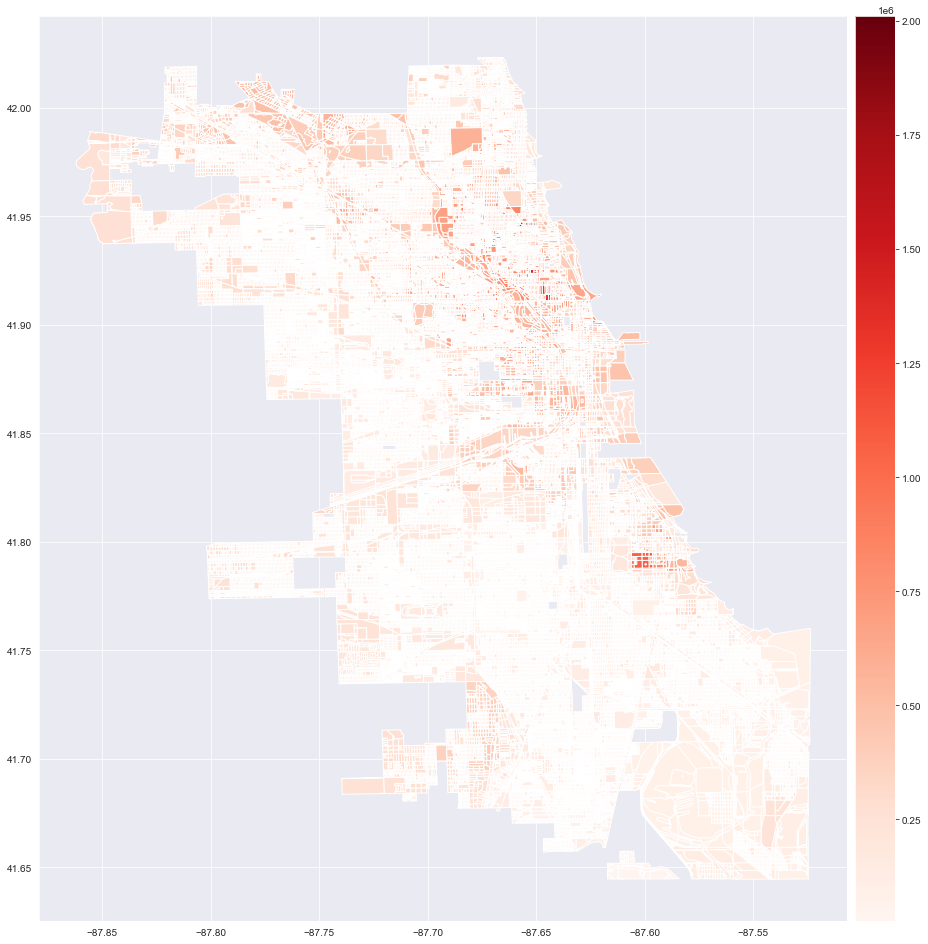

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax = pred_2020_block.plot(column='predicted_price_p_house', legend=True, cmap='Reds', ax=ax, cax=cax)

fig.tight_layout()

In [80]:
pred_2020_neigh.head()

pri_neigh    sec_neigh     shape_area     shape_len  \
0  Grand Boulevard  BRONZEVILLE  48492503.1554  28196.837157   
0  Grand Boulevard  BRONZEVILLE  48492503.1554  28196.837157   
0  Grand Boulevard  BRONZEVILLE  48492503.1554  28196.837157   
0  Grand Boulevard  BRONZEVILLE  48492503.1554  28196.837157   
0  Grand Boulevard  BRONZEVILLE  48492503.1554  28196.837157   

                                            geometry  index_right  \
0  MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ...        41868   
0  MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ...        41912   
0  MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ...        41913   
0  MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ...        41910   
0  MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ...        41924   

   predicted_price_p_house        geo_12  
0            328709.678638  170318359001  
0            244394.534964  170318359003  
0            244394.534964  170318359003  
0            244394.534964  170318359003  
0            244394.534964  170318359003

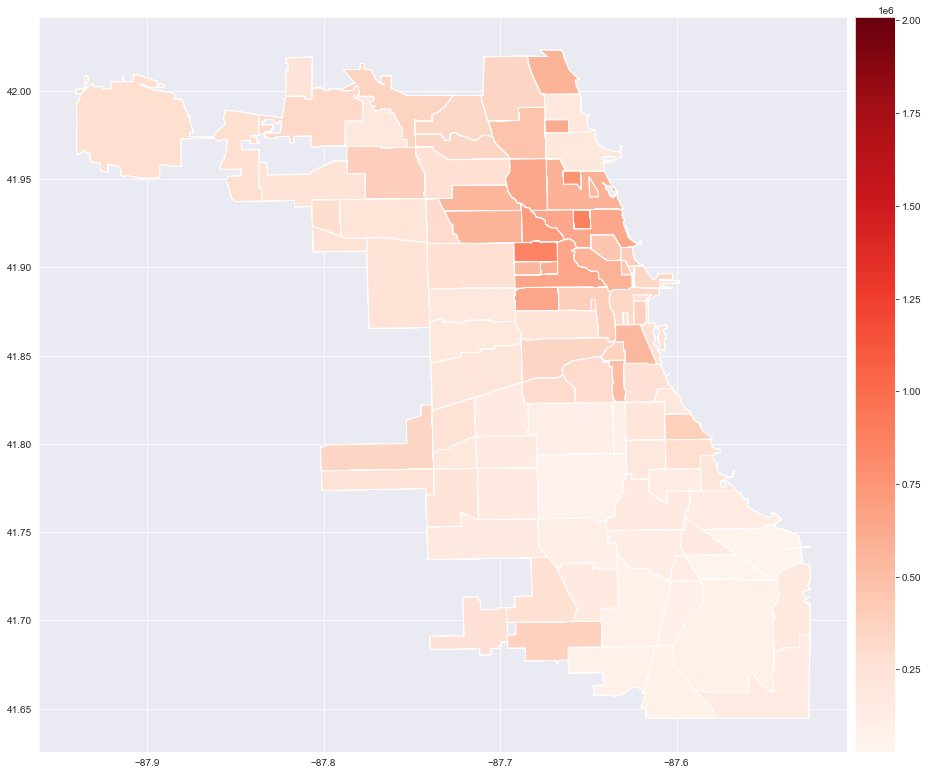

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax = pred_2020_neigh.plot(column='predicted_price_p_house', legend=True, cmap='Reds', ax=ax, cax=cax)

fig.tight_layout()